In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.optimize import minimize
from scipy.special import gamma
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from gzbuilder_analysis.parsing import sanitize_param_dict
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import sersic2d, oversampled_sersic_component, _b
from gzbuilder_analysis.fitting.jupyter import UpdatableDisplay
import lib.galaxy_utilities as gu
from tqdm import tqdm
from numba import jit, prange, vectorize

In [3]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')
simard_df = pd.read_csv('lib/simard-catalog.csv', index_col=0)
best_models = pd.read_pickle('lib/best_individual.pickle')

In [4]:
PARAMS = np.array(('roll', 'rEff', 'axRatio', 'i0'))
def comp_to_p(d):
  mu = np.array(d['mu'])
  return np.concatenate((mu, [d[k] for k in PARAMS]))

def comp_from_p(p):
  return dict(mu=p[:2], **{k: v for k, v in zip(PARAMS, p[2:])})

In [5]:
s0 = 'float32('+('float32,'*9)+')'
s1 = 'float64('+('float64,'*9)+')'
@vectorize([s0, s1], target='parallel')
def _sersic_func(x, y, mux, muy, roll, rEff, axRatio, i0, n):
  out = 0.0
  ds = [-0.4, -0.2, 0.0, 0.2, 0.4]
  for dx in ds:
    for dy in ds:
      out += sersic2d(
        x + dx, y + dy,
        mu=(mux, muy), roll=roll, rEff=rEff,
        axRatio=axRatio, i0=i0, c=2, 
        n=n
      ) / 25
  return out


In [25]:
def bulge_disk_model(p, cx, cy):
    disk = _sersic_func(cx, cy, *p[:6], 1)
    bulge = _sersic_func(cx, cy, *p[6:12], 4)
#     disk = sersic2d(cx, cy, mu=p[:2], roll=p[2], rEff=p[3],
#                     axRatio=p[4], c=2, i0=p[5], n=1.0)
#     bulge = sersic2d(cx, cy, mu=p[6:8], roll=p[8], rEff=p[9],
#                      axRatio=p[10], c=2, i0=p[11], n=4.0)
    return disk + bulge

In [26]:
def f(p, target, cx, cy, psf=np.ones((1,1)), pixel_mask=np.ones(1),
      loss=mean_squared_error):
  im = bulge_disk_model(p, cx, cy)
  im_psf = convolve2d(
    im, psf, mode='same', boundary='symm'
  )
  return loss(target * pixel_mask, im_psf * pixel_mask)

In [29]:
display(_m)
display(p0)

{'disk': {'mu': array([32.53491211, 32.5390625 ]),
  'roll': -0.025635408521677425,
  'rEff': 25.90694972290857,
  'axRatio': 0.6071298668687596,
  'i0': 0.12,
  'c': 2,
  'n': 1},
 'bulge': {'mu': array([35.05834961, 33.0703125 ]),
  'roll': 0.08314123188844122,
  'rEff': 5.8334124206994575,
  'axRatio': 0.48698760942986274,
  'i0': 0.71,
  'c': 2,
  'n': 0.5},
 'bar': None,
 'spiral': array([], dtype=float64)}

array([ 3.25349121e+01,  3.25390625e+01, -2.56354085e-02,  2.59069497e+01,
        6.07129867e-01,  1.20000000e-01,  3.50583496e+01,  3.30703125e+01,
        8.31412319e-02,  5.83341242e+00,  4.86987609e-01,  7.10000000e-01])

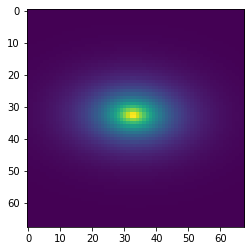

In [32]:
plt.imshow(oversampled_sersic_component(m['disk'], image_size))

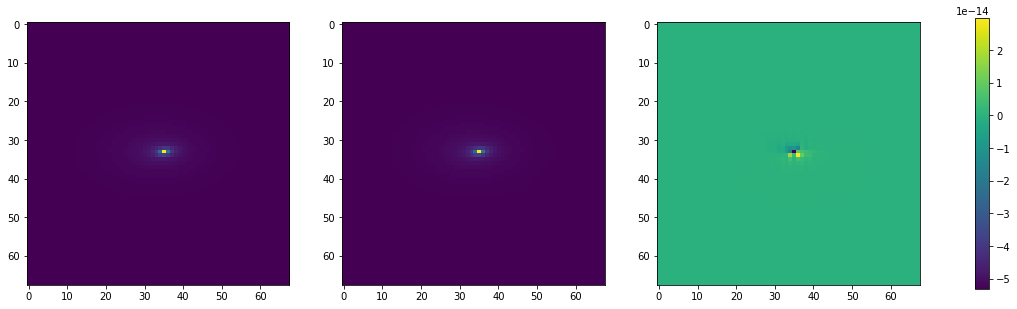

In [44]:
i = best_models.index[0]
m = best_models.loc[i]['Model']
p0 = np.concatenate((comp_to_p(m['disk']), comp_to_p(m['bulge'])))
_m = {'disk': dict(m['disk']), 'bulge': dict(m['bulge']), 'bar': None, 'spiral': np.array([])}
_m['bulge']['n'] = 4
image_size = gu.get_diff_data(i)['width']
psf = gu.get_psf(i)
cx, cy = np.mgrid[0:image_size, 0:image_size]

im = bulge_disk_model(p0, cy, cx)

im2 = rendering.calculate_model(
   _m, psf=None, image_size=image_size
)
f, ax = plt.subplots(ncols=3, figsize=(20, 5))
ax[0].imshow(im)
ax[1].imshow(im2)
c = ax[2].imshow(im - im2)
plt.colorbar(c, ax=ax)

In [ ]:
BOUNDS = [
  (0, 512), (0, 512),  # mux, muy
  (-np.inf, np.inf), (-np.inf, np.inf), # roll, rEff
  (0, np.inf),  # axRatio
  (0, np.inf), # i0
] * 2

In [ ]:
def get_fitted_bd_model(subject_id, progress=True):
  psf = gu.get_psf(subject_id)
  diff_data = gu.get_diff_data(subject_id)
  pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
  galaxy_data = np.array(diff_data['imageData'])[::-1]

  m = best_models.loc[subject_id]['Model']
  if m['disk'] is None or m['bulge'] is None:
    return None
  p0 = comp_to_p(m['disk']) + comp_to_p(m['bulge'])
  image_size = galaxy_data.shape[0]
  cx, cy = np.mgrid[0:image_size, 0:image_size]
  if progress:
    with tqdm(desc='Fitting model', leave=False) as pbar:
      def update_bar(p):
        pbar.update(1)
      res = minimize(
        f, p0, callback=update_bar,
        args=(galaxy_data, cx, cy, psf, pixel_mask),
        bounds=BOUNDS
      )
  else:
    res = minimize(
      f, p0, callback=update_bar,
      args=(galaxy_data, cx, cy, psf, pixel_mask)
    )
  fit_disk = sanitize_param_dict(
    comp_from_p(res['x'][:6].tolist())
  )
  fit_bulge = sanitize_param_dict(
    comp_from_p(res['x'][6:].tolist())
  )
  return fit_disk, fit_bulge, res

In [ ]:
out = pd.Series([]).rename('fit_results')

In [ ]:
d = UpdatableDisplay('')
for i, subject_id in enumerate(sid_list):
  d('{} / {} : {}'.format(i, len(sid_list), subject_id))
  if subject_id in out.index:
    continue
  try:
    out[subject_id] = get_fitted_bd_model(subject_id)
  except KeyboardInterrupt:
    break

Calculate bulge to total fractions:

In [ ]:
def get_flux(**comp):
  re = comp['rEff'] / 3
  Se = comp['i0'] / 2
  n = comp['n']
  k = _b(n)
  q = comp['axRatio']
  return 2 * np.pi * re**2 * Se * np.exp(k) * n * k**(-2*n) * gamma(2*n) / q

def get_bt(disk, bulge):
  b = get_flux(n=4, **bulge)
  t = b + get_flux(n=1, **disk)
  return b / t

In [ ]:
bt = out.dropna().apply(lambda r: get_bt(r[0], r[1]))

In [ ]:
st.pearsonr(bt, simard_df['__B_T_r'].loc[bt.index])

In [ ]:
plt.figure(figsize=(6, 6), dpi=75)
plt.plot(simard_df['__B_T_r'].loc[bt.index], bt, '.')
plt.gca().add_artist(plt.Line2D((0, 1), (0, 1), color='k', alpha=0.2))
plt.axis('equal')
plt.xlim(0, .9)
plt.ylim(0, .9)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)
subject_id = np.random.choice(out.dropna().index)
psf = gu.get_psf(subject_id)
diff_data = gu.get_diff_data(subject_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
r = comp_to_p(out.loc[subject_id][0]) + comp_to_p(out.loc[subject_id][1])
image_size = galaxy_data.shape[0]
cx, cy = np.mgrid[0:image_size, 0:image_size]
im_psf = convolve2d(
  bulge_disk_model(r, cx, cy), psf, mode='same', boundary='symm'
)
plt.subplot(231)
plt.imshow(galaxy_data, vmin=0, vmax=1)
plt.subplot(232)
s = mean_squared_error(galaxy_data * pixel_mask, im_psf * pixel_mask)
plt.title('{}: {:.4f}'.format(subject_id, s))
plt.imshow(im_psf, vmin=0, vmax=1)
plt.subplot(233)
full_model = rendering.calculate_model(
    best_models.loc[subject_id]['Model'],
    psf=gu.get_psf(subject_id),
    image_size=gu.get_diff_data(subject_id)['width'],
)
s2 = mean_squared_error(galaxy_data * pixel_mask, full_model * pixel_mask / 0.8)
plt.title(s2)
plt.imshow(full_model, vmin=0, vmax=1)
plt.subplot(235)
d = galaxy_data * pixel_mask - im_psf * pixel_mask
plt.imshow(d / 0.8, cmap='RdGy', vmin=-np.abs(d).max(), vmax=np.abs(d).max())
plt.subplot(236)
d2 = rendering.compare_to_galaxy(
    full_model, galaxy_data, psf=None, pixel_mask=pixel_mask, stretch=False
)
plt.imshow(d2, cmap='RdGy', vmin=-np.abs(d).max(), vmax=np.abs(d).max())

In [ ]:
out.loc[subject_id][2]

In [ ]:
best_models.loc[20902040]

In [ ]:
simard_df.loc[subject_id].keys()

In [ ]:
simard_df.loc[subject_id]['__B_T_r']

In [ ]:
sanitize_param_dict(fit_disk)['axRatio'], 1 / np.arctan(simard_df.loc[subject_id]['i'])

In [ ]:
sanitize_param_dict(fit_bulge)['axRatio'], 1 - simard_df.loc[subject_id]['e']